In [1]:
import os, sys
from pathlib import Path
sys.version

os.sys.path.append(Path().cwd().parent.as_posix())

In [2]:
from src.MyModule.utils import *

config = load_config()
config['epsilon']

[0, 0.1, 1, 10, 100, 1000, 10000]

In [60]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import shap

In [61]:
result_path = get_path('data/processed/4_results/shap_values')
figure_path = get_path('figures')

#%%
def load_shap_value(model_name, epsilon, age) :

    shap_path = result_path.joinpath(f"{model_name}_{age}_{epsilon}.pkl")
    with open(shap_path, 'rb') as f:
        shap_values = pickle.load(f)
    return shap_values

def load_test_data() :
    test_data_path = get_path('data/processed/1_preprocess/test_50.pkl')
    test = pd.read_pickle(test_data_path)

    test_x = test.drop(['DEAD','DEAD_DIFF','PT_SBST_NO','OVR_SURV'], axis=1)
    test_y = test['DEAD']

    return test_x

testD = load_test_data()

#%%
shapValues = [load_shap_value("DecisionTree", eps, 50)[0].mean(axis=0) for eps in config['epsilon']]
shapvalue = load_shap_value("DecisionTree", 0.1, 50)

In [69]:
a = testD.fillna(999).values

TypeError: only integer scalar arrays can be converted to a scalar index

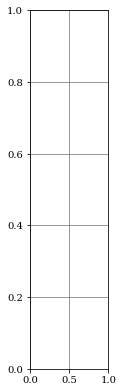

In [70]:
shap.summary_plot(shapvalue, a)

In [55]:
shapvalue.mean(axis=0)

.values =
array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.00027004,  0.00027004],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0

In [34]:
pd.DataFrame(shapvalue.mean(axis=0), columns)

ValueError: DataFrame constructor not properly called!

In [5]:
columns = testD.columns.tolist()

In [11]:
def generate_shap_figure(
        figsize: Tuple[float, float], 
        fontsize: float, 
        xlim: Tuple[float, float],
        shap_values: List[np.ndarray], 
        columns: List[str] or np.ndarray,
        top_limit: int = None, 
        sort_desc: bool = True, 
        save_file_name: str = None,
    ):

    '''
    requires : figsize, fontsize, xlim, shap_values
    '''

    # matplotlib.use('TkAgg')
    f = plt.figure(figsize=figsize)

    for i, alphabet, icu, column, shap in zip(
            [1, 2, 3, 4, 5, 6, 7], 
            ['a', 'b', 'c', 'd', 'e', 'f', 'g'], 
            ['$\epsilon$ 0', '$\epsilon$ 0.1', '$\epsilon$ 1', '$\epsilon$ 10', '$\epsilon$ 100', '$\epsilon$ 1,000', '$\epsilon$ 10,000'],
            columns,
            shap_values):

        plt.rcParams.update({"axes.grid": True, "grid.color": "grey"})
        plt.rcParams['font.family'] = 'DeJavu Serif'
        plt.rcParams['font.serif'] = ['Times New Roman']

        ax = f.add_subplot(int(f'31{i}'))

        if isinstance(columns, dict) :
            column = columns[column]

        df_tmp = pd.DataFrame(shap, column)

        if sort_desc: df_tmp = df_tmp.sort_values(0, ascending=sort_desc)
        if top_limit: df_tmp = df_tmp.iloc[:top_limit]

        ax.barh(df_tmp.index.tolist(), df_tmp.values.reshape((-1)))
        ax.set_title(f'({alphabet}) {icu}', fontsize=fontsize)

        if (i == 3) or (i == 4):
            ax.set_xlabel('mean absolute SHAP value', fontsize=fontsize)

        else:
            pass
        ax.set_xlim(*xlim)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize - 3)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize - 3)

    f.tight_layout()

    if save_file_name:
        plt.savefig(save_file_name, dpi=500)
    else:
        plt.show()

ValueError: DataFrame constructor not properly called!

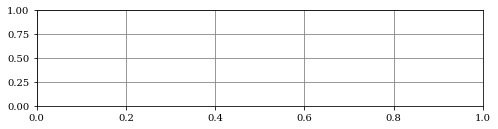

In [12]:
generate_shap_figure((8,6), 13, xlim = (0, 0.1),
                     shap_values=shapValues,
                     columns = columns,
                     sort_desc=True,
                     save_file_name=False)

In [12]:
def plot_example_run():

    with open(dataPath.joinpath('processed/feature_book_eng.yaml'), 'rb') as f:
        feature_book = yaml.load(f, Loader=yaml.FullLoader)

    h_cols = feature_book['common_features']

    v_cols = { "hicu" : h_cols + feature_book['hicu_specific'],
              "micu" : h_cols + feature_book['micu_specific'],
              "sicu" : h_cols + feature_book['sicu_specific'] }

    clients = ['hicu', 'micu', 'sicu']

    # load datas
    client_datas = {client : create_train_valid_data(client) for client in clients}

    # load models
    horizontal_models = { client : load_model(client, vertical=False) for client in clients }
    ppfl_models = { client : load_model(client, vertical=True) for client in clients }

    # HFL MEAN ABSOLUTE SHAP
    hfl_value_lst = [
        generate_mean_shap_values(
            model= horizontal_models[client], absolute=True,
            init_common_inputs=client_datas[client]['init_common_inputs'],
            test_common_inputs=client_datas[client]['test_common_inputs'],
        ) for client in clients
    ]

    generate_shap_figure(
        figsize=(6, 8), fontsize=13, xlim=(0., 0.1),
        shap_values= hfl_value_lst, columns=[h_cols for i in range(0, len(clients))],
        sort_desc=True, save_file_name=Path(figurePath, 'hfl_shap.png'),
    )

    # PPFL MEAN ABSOLUTE SHAP
    ppfl_value_lst = [
        generate_mean_shap_values(
            model= ppfl_models[client],
            init_common_inputs=client_datas[client]['init_common_inputs'],
            init_vertical_inputs=client_datas[client]['init_vertical_inputs'],
            test_common_inputs=client_datas[client]['test_common_inputs'],
            test_vertical_inputs=client_datas[client]['test_vertical_inputs'],
            absolute=True
        ) for client in clients
    ]

    generate_shap_figure(
        figsize=(6, 8), fontsize=13, xlim=(0., 0.008),
        shap_values=ppfl_value_lst, columns=v_cols, top_limit=10,
        sort_desc=True,  save_file_name=Path(figurePath, 'ppfl_shap.png')
    )